In [1]:
import pandas as pd
from glob import glob
import json
import matplotlib.pyplot as plt

In [2]:
files = glob("*.json")
df = None

for f in files:
  f_data = json.load(open(f))
  series = pd.Series()

  model, degree, _, _ = f.split(".")
  series["degree"] = int(degree) + 1
  series["model"] = model

  #series["train_losses"] = f_data["train_losses"]
  #series["train_loss"] = f_data["train_losses"][-1] if len(series["train_losses"]) > 0 else -1

  #series["test_losses"] = f_data["test_losses"]
  #series["test_loss"] = f_data["test_losses"][-1] if len(series["test_losses"]) > 0 else -1

  for rel, val in f_data["relationship_weights"].items():
    series[rel] = val

  metrics = {k: [m[k] for m in f_data["metrics"]] for k in f_data["metrics"][0].keys()}
  #series["metrics"] = metrics

  for k, v in metrics.items():
    series[k] = v[-1]

  series = series.to_frame().T
  if df is None:
    df = series
  else:
    df = pd.concat([df, series])

df.columns = [c.replace("@None", "") for c in df.columns]

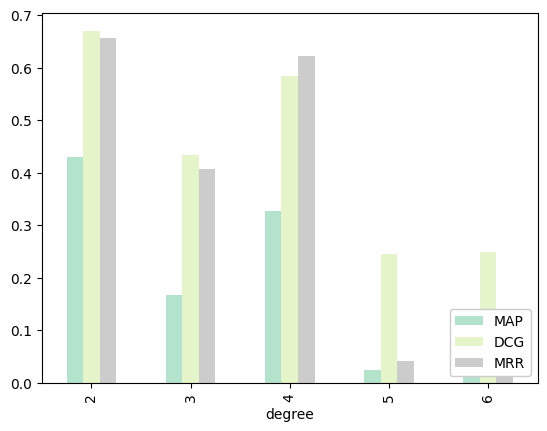

In [3]:
ax = df.groupby(["degree"])[["MAP", "DCG", "MRR"]].mean().plot.bar(cmap="Pastel2")
ax.legend(loc='lower right', framealpha=1)
fig = ax.get_figure()
fig.savefig('degree-plot.png', dpi=300)

ValueError: The number of FixedLocator locations (1), usually from a call to set_ticks, does not match the number of labels (5).

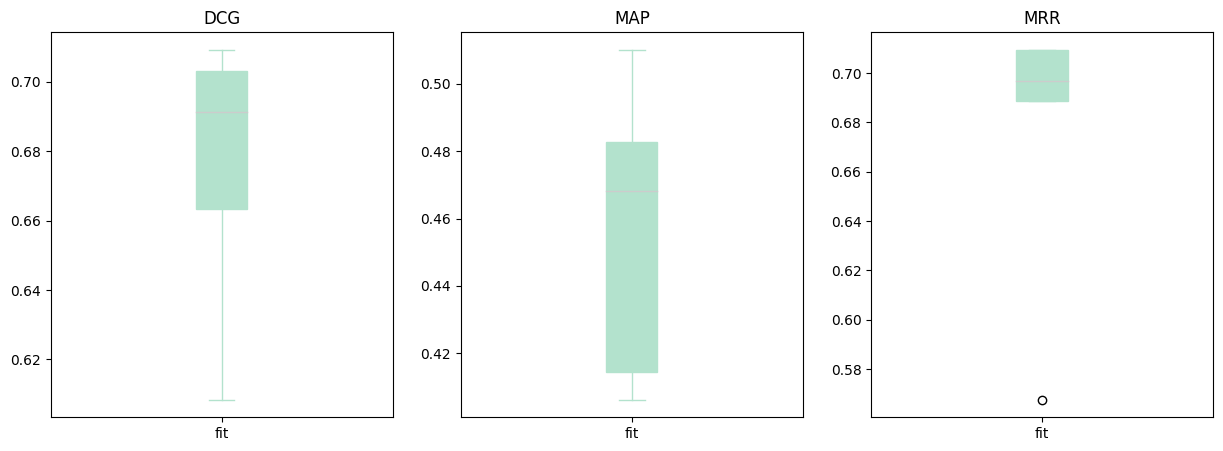

In [4]:
axs = df[df.degree == 2].plot.box(column=["MAP", "DCG", "MRR"], cmap="Pastel2", by="model", figsize=(15, 5), patch_artist=True)

for ax in axs:
  ax.set_xticklabels(["DNN", "Learned", "freq", "freq$^-1$", 1])


In [4]:
print(df.groupby("model")[["MAP", "DCG", "MRR"]].std().to_latex(float_format="{:.2f}".format))

\begin{tabular}{lrrr}
\toprule
 & MAP & DCG & MRR \\
model &  &  &  \\
\midrule
fit & 0.17 & 0.18 & 0.28 \\
\bottomrule
\end{tabular}



In [7]:
columns = [
  'http://w3id.org/friendshipneverends/ontology/sameRecordLabel',
  'http://w3id.org/friendshipneverends/ontology/isFriendOf',
  'http://w3id.org/friendshipneverends/ontology/hasAcquaintance',
  'http://w3id.org/friendshipneverends/ontology/hasPupil',
  'http://w3id.org/friendshipneverends/ontology/hasBandmate',
  'http://w3id.org/friendshipneverends/ontology/hasFriend',
  'http://w3id.org/friendshipneverends/ontology/hasMentor',
  'MRR',
  'MAP', 
  'DCG'
]

In [8]:
df[columns].corr().loc[["MRR", "MAP", "DCG"], columns[:-3]]

,http://w3id.org/friendshipneverends/ontology/sameRecordLabel,http://w3id.org/friendshipneverends/ontology/isFriendOf,http://w3id.org/friendshipneverends/ontology/hasAcquaintance,http://w3id.org/friendshipneverends/ontology/hasPupil,http://w3id.org/friendshipneverends/ontology/hasBandmate,http://w3id.org/friendshipneverends/ontology/hasFriend,http://w3id.org/friendshipneverends/ontology/hasMentor
MRR,-0.273524,-0.141902,0.474040,0.177580,0.393055,0.420436,-0.140645
MAP,-0.074771,0.074115,0.630914,0.017461,0.558481,0.424795,0.064513
DCG,-0.147945,-0.005950,0.585168,0.085230,0.510909,0.430495,-0.011388


In [9]:
import numpy as np
small_df = df[(df.model == "fit") & (df.degree == 2)].groupby(["degree", "model"]).agg(["median", "mean", "min", "max"])[columns[:-3]].T.reset_index()
small_df.columns = small_df.columns.get_level_values(0)
small_df = small_df.pivot(columns="level_1", index="level_0", values=2)

In [10]:
print(small_df.to_latex())

\begin{tabular}{lllll}
\toprule
level_1 & max & mean & median & min \\
level_0 &  &  &  &  \\
\midrule
http://w3id.org/friendshipneverends/ontology/hasAcquaintance & 9.503822 & 9.233640 & 9.317330 & 8.771275 \\
http://w3id.org/friendshipneverends/ontology/hasBandmate & 8.602548 & 6.935402 & 7.274861 & 4.864461 \\
http://w3id.org/friendshipneverends/ontology/hasFriend & 18.161931 & 14.007161 & 13.351510 & 11.732520 \\
http://w3id.org/friendshipneverends/ontology/hasMentor & 2.733682 & 2.475175 & 2.432023 & 2.351803 \\
http://w3id.org/friendshipneverends/ontology/hasPupil & 16.023189 & 10.308693 & 9.426541 & 5.929726 \\
http://w3id.org/friendshipneverends/ontology/isFriendOf & 2.733416 & 2.475215 & 2.432089 & 2.351827 \\
http://w3id.org/friendshipneverends/ontology/sameRecordLabel & 2.853550 & 2.503548 & 2.448387 & 2.354468 \\
\bottomrule
\end{tabular}

